<h1>Self Organising Maps for Edinburgh based in SIMD 2016</h1>

This notebook shows the code applied to produce better insights into deprived areas of the City of Edinburgh.
This Notebook was written in Kaggle and therefore it is not necessary to download packages.

In [1]:
#import all the necessary libraries
library(tidyverse)
list.files(path = "../input")
library(kohonen)
library(raster)
library(ggplot2)
library(rgdal)
library(gridExtra)
library(grid)
library(viridis)
library(plyr) 
library(dplyr)
library(plotly)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.3.0.9000     ✔ purrr   0.3.3     
✔ tibble  2.1.3          ✔ dplyr   0.8.4     
✔ tidyr   1.0.2          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "edi-shapes"  "rural-urban" "simd-null"   "simd-table"


Attaching package: ‘kohonen’


The following object is masked from ‘package:purrr’:

    map


Loading required package: sp


Attaching package: ‘raster’


The following object is masked from ‘package:dplyr’:

    select


The following object is masked from ‘package:tidyr’:

    extract


rgdal: version: 1.4-8, (SVN revision 845)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.1.2, released 2016/10/24
 Path to GDAL shared files: /usr/share/gdal/2.1
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.3-2 


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: viridisLite

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functi

Using Gdal to read the shapfile and transform it to WGS84

In [2]:
edinburgh_shape <- readOGR("../input/edi-shapes/SG_SIMD_2016_EDINBURGH.shp", stringsAsFactors = FALSE)
edi_map <- spTransform(edinburgh_shape, CRS("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"))

#calculating the area of each neighbourhood in km2
edi_map$area_sqkm <- area(edi_map) / 1000000
rural_urban <- read.csv("../input/rural-urban/Rural_Urban.csv", sep=";")
rural_urban <- as.data.frame(rural_urban)

OGR data source with driver: ESRI Shapefile 
Source: "/kaggle/input/edi-shapes/SG_SIMD_2016_EDINBURGH.shp", layer: "SG_SIMD_2016_EDINBURGH"
with 597 features
It has 50 fields


The shapefile is not essential for training the data, therefore the attribute will first be extracted from the Shapefile and in later step merged together

There are NA values in three variables. The missing values in Crime Count and Crime Rate can be used as 0, since "Crime counts smaller than three were suppressed" (SIMD supporting document)

In terms of Education attainment a value of 0 would have distorted the results. Unfortunelty, the SOM does not deal well with NA values. Therefore, the NA values (3 observations) were given the mean of the variable.

In [3]:
# get the data from the shapefile
edi_map@data$id <- rownames(edi_map@data)
edi.df <- edi_map@data
edi.df <- merge(x = edi.df, y = rural_urban, by.x = "DataZone", by.y = "FeatureCode")
#caculate the population per km2 for further insights
edi.df$Pop_Area <- round(edi.df$SAPE2014/edi.df$area_sqkm,, digits = 0)

# calculate the mean of the attainment variable to give assign it nan values
attain_mean <- mean(edi.df$EduAttain)
edi.df$EduAttain[edi.df$DataZone == "S01008849" | edi.df$DataZone == "S01008854" |
                   edi.df$DataZone == "S01008669"] <- attain_mean #which is the mean 
# any other nan (crime) shall be 0
edi.df[is.na(edi.df)] <- 0
edi.df <- edi.df %>% 
  rename(
    UrbanRank = Value
    )


Due to the fact that all domain ranks are in a ordinal scale and that inherits a loss of information, each domain will get a new column that exists of all variables of the domain normalized to 0 to 1 and then added. Where varibales are just another expression of the same meaning (like rate and abolsute number) only the rate is considered.

In [4]:
# specifying a function to noramlize data
normalize <- function(x){(x-min(x))/(max(x)-min(x))}

#Health

Health.df <- dplyr::select(edi.df,HlthCIF,HlthAlcSR,HlthDrugSR,HlthSMR,HlthDprsPc,HlthLBWTPc,HlthEmrgSR) %>% apply(2, normalize) %>% data.frame()
Health <- rowSums(Health.df)
edi.df$Health <- Health
# a high value in Health means deprived

#Education

Education.df <- dplyr::select(edi.df,EduAttend,EduAttain,EduNoQuals,EduNEET,EduHESA) %>% apply(2, normalize) %>% data.frame()
Education <- (1-Education.df$EduAttend) +Education.df$EduNoQuals+Education.df$EduNEET + (1-Education.df$EduHESA) + (1-Education.df$EduAttain)
edi.df$Education <- Education
# a high value in Education means deprived
#in some variables high value meant a low deprivation and therefore (1- X) was applied

#Access

Access.df <- dplyr::select(edi.df,GAccPetrol,GAccDTGP,GAccDTPost,GAccDTPsch,GAccDTRet,GAccDTSsch,GAccPTGP,GAccPTPost,GAccPTRet) %>% apply(2, normalize) %>% data.frame()
Access <- rowSums(Access.df) 
Access_car <- edi.df$GAccPetrol + edi.df$GAccDTGP + edi.df$GAccDTPost + edi.df$GAccDTPsch+ edi.df$GAccDTRet + edi.df$GAccDTSsch 
Access_public <- edi.df$GAccPTGP+ edi.df$GAccPTPost+ edi.df$GAccPTRet
edi.df$Access <- Access
edi.df$Access_car <- Access_car
edi.df$Access_public <- Access_public
# a high value in Access means deprived

#Housing

Housing.df <- dplyr::select(edi.df,HouseOCrat,HouseOCrat) %>% apply(2, normalize) %>% data.frame()
Housing <- rowSums(Housing.df)
edi.df$Housing <- Housing
# a high value in Housing means deprived

#Wealth (Health, Income and Employment combined)
wealth.df <- dplyr::select(edi.df,Health, EmpRate, IncRate) %>% apply(2, normalize) %>% data.frame()
Wealth <- rowSums(Housing.df)
edi.df$Wealth <- Wealth
#check if the number of rows is still correct
nrow(edi.df)


[1] 597

    
<h3>This are the column names, we can choose from for the SOM</h3>
Please see for specifcation the documentation

* **Pop**: DataZone,LAName,SAPE2014,WASAPE2014,Pop_area
* **Rank**: Rank,Quintile,Decile,Vigintile, Percentile
* **Income**: IncRate, IncNumDep, IncRank
* **Employment**: EmpRate, EmpNumDep, EmpRank 
* **Health**: HlthCIF,HlthAlcSR,HlthDrugSR,HlthSMR,HlthDprsPc,HlthLBWTPc,HlthEmrgSR,HlthRank, Health
* **Education**: EduAttend,EduAttain,EduNoQuals,EduNEET,EduHESA,EduRank, Education
* **Access**: GAccPetrol,GAccDTGP,GAccDTPost,GAccDTPsch,GAccDTRet,GAccDTSsch,GAccPTGP,GAccPTPost,GAccPTRet,GAccRank,Access
* **Crime**: CrimeCount,CrimeRate,CrimeRank
* **Housing**: HouseNumOC,HouseNumNC,HouseOCrat,HouseNCrat,HouseRank, Housing
* **Geomtry**: Shape_Leng,Shape_Area,Intermedia,id,Area_sqrt, pop_area

Select variables to gain insights of its distribution and dependency on others


In [5]:
set.seed(1) #make process repreatable and same
#seed "1" for all domains
#set the variables, that are interesting
outlier <- function(x, probs = c(0.01, 0.99)) {
  #assign values above and below the percentiles 
    #the value of that percentile
  ranges <- quantile(x, probs = probs, na.rm = T)
  x[x < ranges[1]] <- ranges [1]
  x[x > ranges[2]] <- ranges [2]
  return(x)
}
#EduAttend,EduAttain,EduNoQuals,EduNEET,EduHESA, Education
training <- dplyr::select(edi.df,IncRate, EmpRate,Education, Health, Access, Housing, CrimeRate) %>% apply(2, outlier) %>% data.frame()
data_train <- dplyr::select(training,IncRate, EmpRate,Education, Health, Access, Housing, CrimeRate)

data_train_matrix <- as.matrix(scale(data_train))
names(data_train_matrix) <-(data_train)

# get the numbe rof observations
rows <- nrow(data_train_matrix)
#determine the size of the grid by determing that ideally 10 observations are in one node
xy <- round(sqrt(5*sqrt(rows)), digits = 0)

summary(data_train_matrix)

    IncRate           EmpRate          Education           Health       
 Min.   :-0.9554   Min.   :-0.9766   Min.   :-1.8511   Min.   :-1.3799  
 1st Qu.:-0.7290   1st Qu.:-0.7111   1st Qu.:-0.7777   1st Qu.:-0.7717  
 Median :-0.3893   Median :-0.3130   Median :-0.1337   Median :-0.2715  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.4031   3rd Qu.: 0.4833   3rd Qu.: 0.8016   3rd Qu.: 0.5803  
 Max.   : 3.3509   Max.   : 3.6684   Max.   : 2.2017   Max.   : 2.9664  
     Access           Housing          CrimeRate      
 Min.   :-1.8270   Min.   :-1.3744   Min.   :-1.0015  
 1st Qu.:-0.7239   1st Qu.:-0.8602   1st Qu.:-0.6195  
 Median :-0.1065   Median :-0.1459   Median :-0.2716  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.5370   3rd Qu.: 0.6319   3rd Qu.: 0.2191  
 Max.   : 2.9929   Max.   : 2.7165   Max.   : 5.1406  

This function will initilazie the SOM model and train the data

In [6]:
# create a grid, using toroidal and gaussian accroding to Kiang et al. (2001) and Stefanovič & Kurasova (2011)
som_grid <- somgrid(xdim = xy, ydim=xy, topo="hexagonal", neighbourhood.fct = "gaussian", toroidal = TRUE)

som_model <-som(data_train_matrix,
               grid=som_grid,
               rlen=1000, #
               alpha=c(0.1,0.01), #learning rate adopted from practical
               keep.data= TRUE)


The next cell will plot various plots to get a better idea of the usefulness of the model.
This is an explonatory script. Meaning that by observing the outcome some varibales of in the previous cell are being changed.

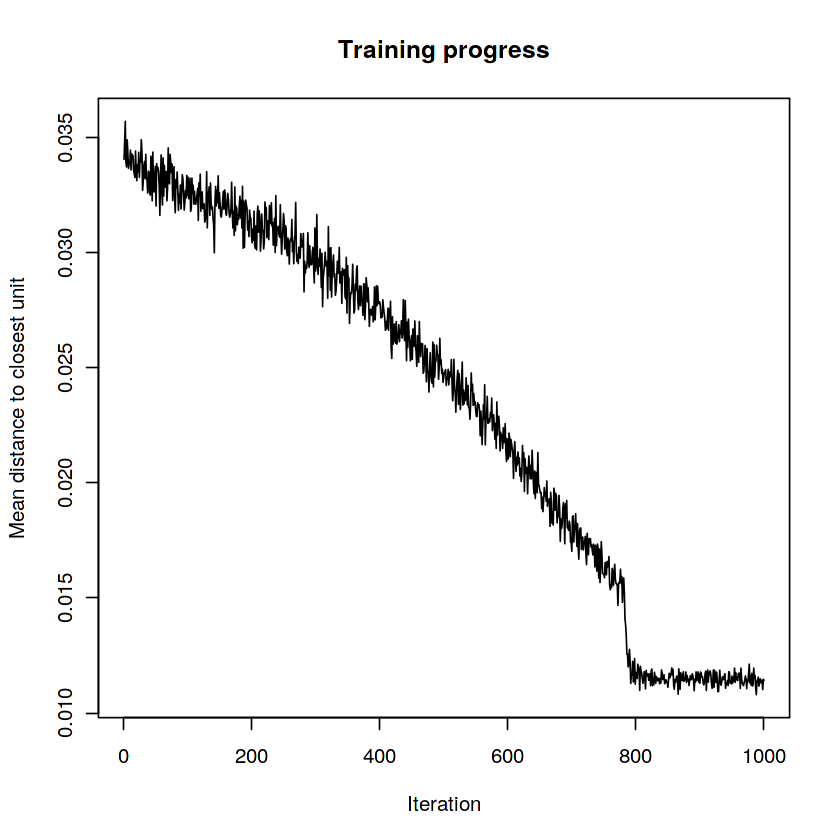

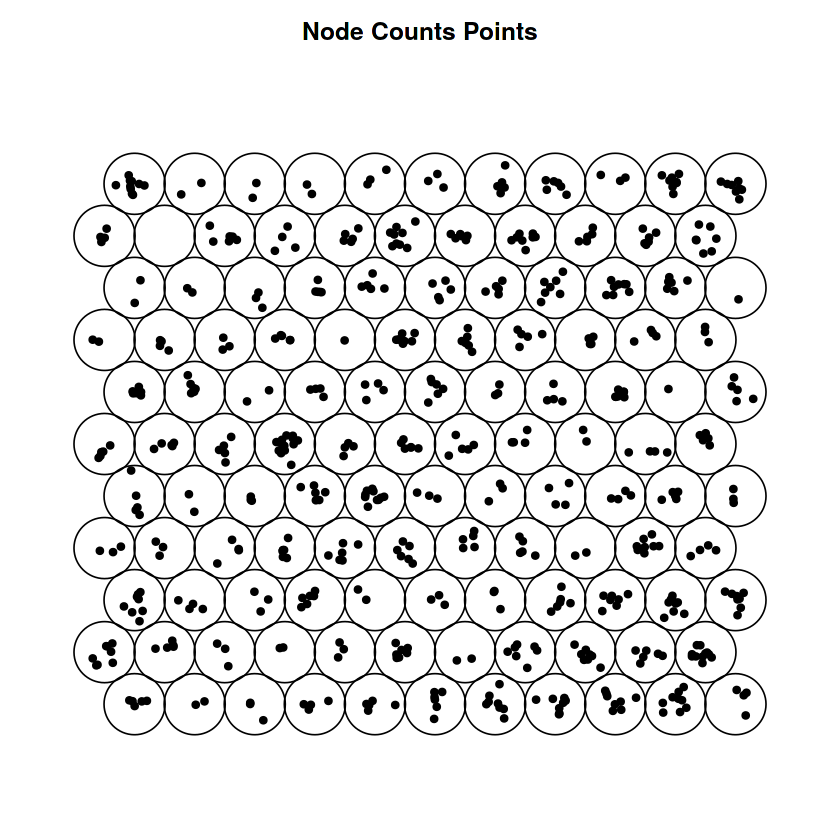

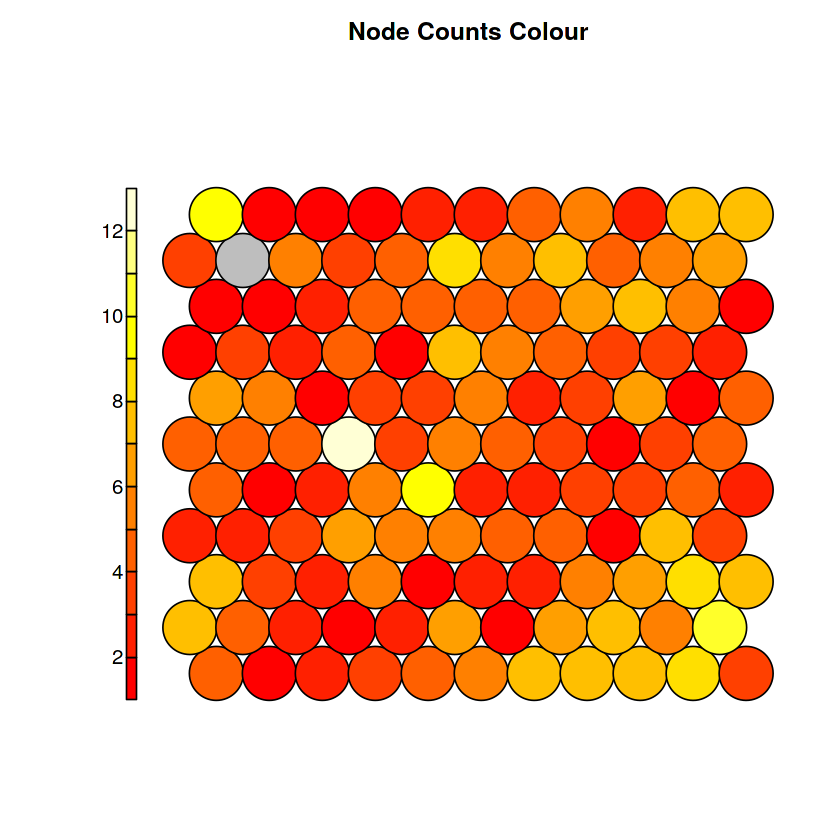

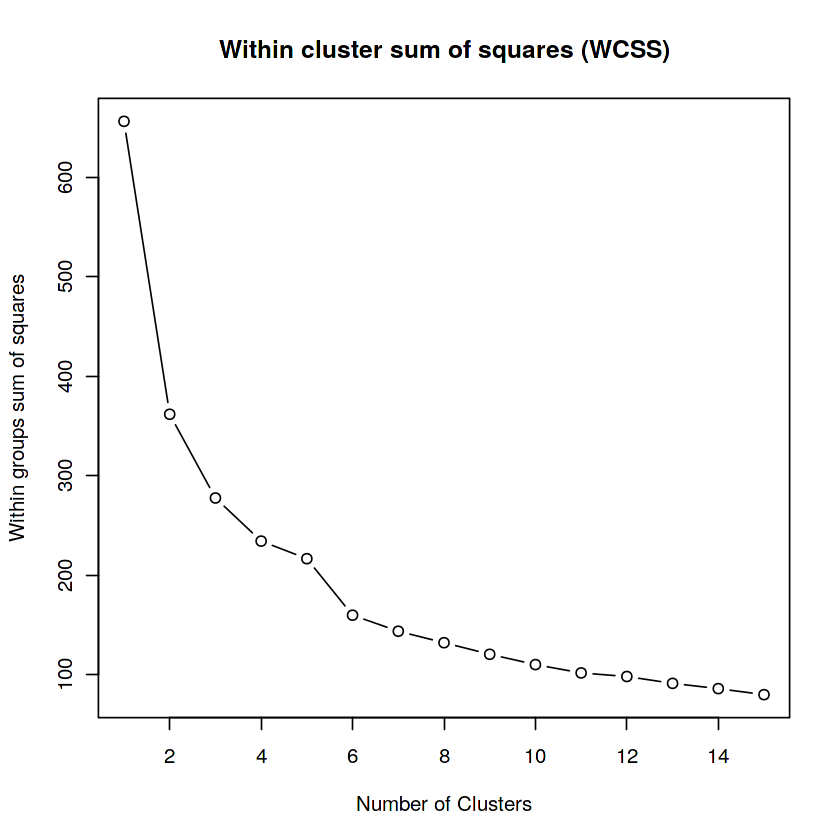

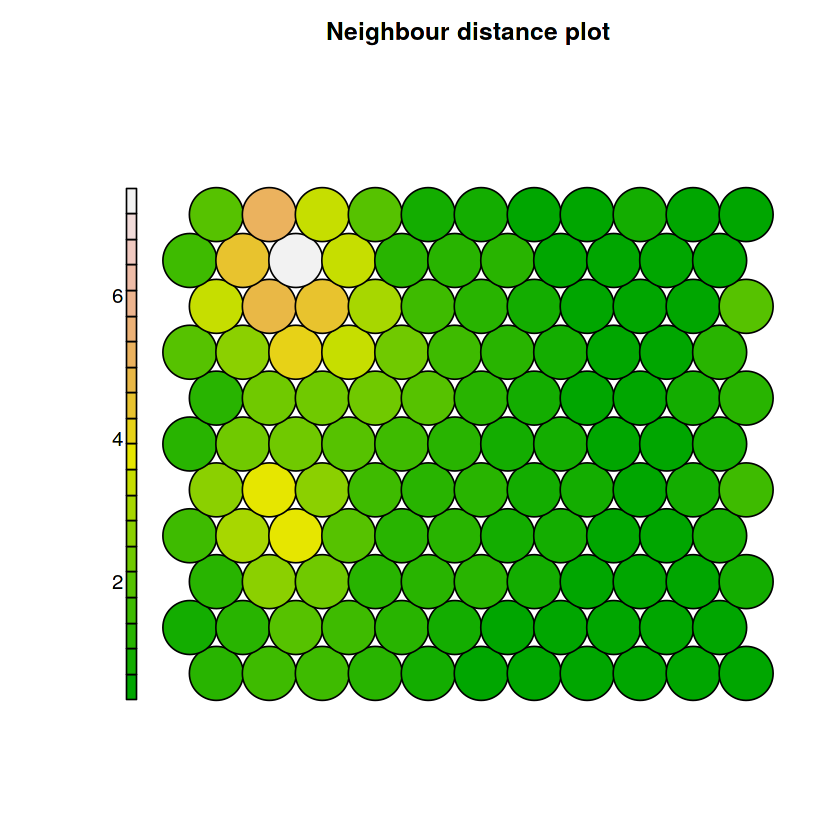

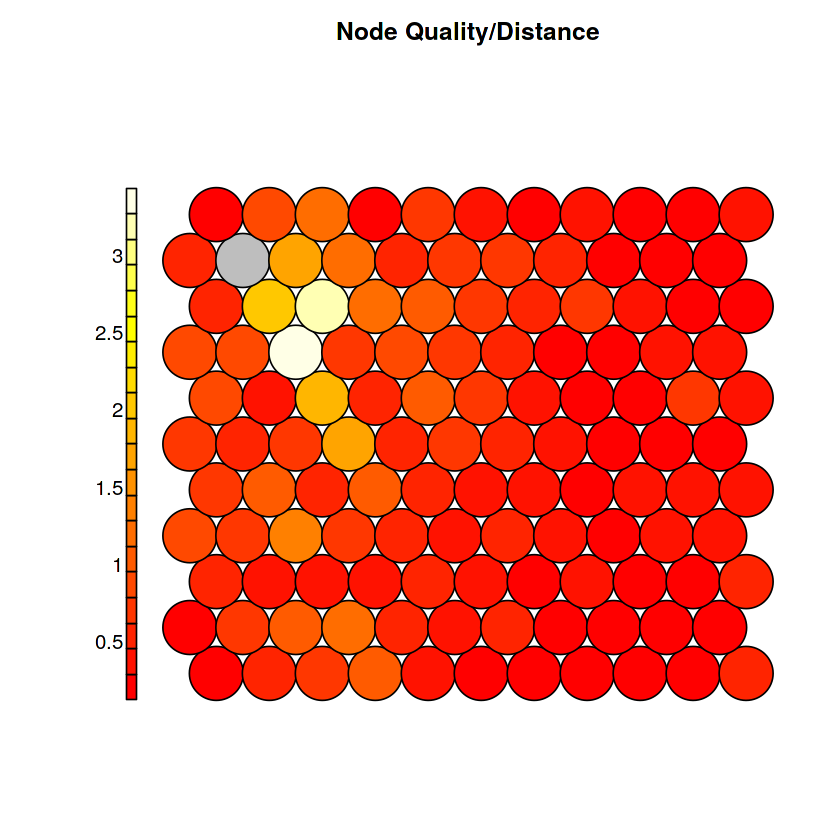

In [7]:
mydata <- getCodes(som_model)
wss <- (nrow(mydata)-1)*sum(apply(mydata,2,var))
for (i in 2:15) wss[i] <- sum(kmeans(mydata, centers=i)$withinss)

plot(som_model, type="changes")
plot(som_model, type = "mapping", pchs = 20, main = "Node Counts Points")

plot(som_model,type="counts",main="Node Counts Colour")
plot(1:15, wss, type="b", xlab="Number of Clusters", ylab="Within groups sum of squares", main="Within cluster sum of squares (WCSS)")

plot(som_model, type = "dist.neighbours", palette.name = terrain.colors)
plot(som_model, type = "quality", main="Node Quality/Distance")

Furthermore, Heatmaps of each variable are computed to compare their characteristics within the SOM. 
If tehy are all having the same characteristics, the correlation must be really high. If they
vary in their kind the SOM will be more divers in their vector characteristics

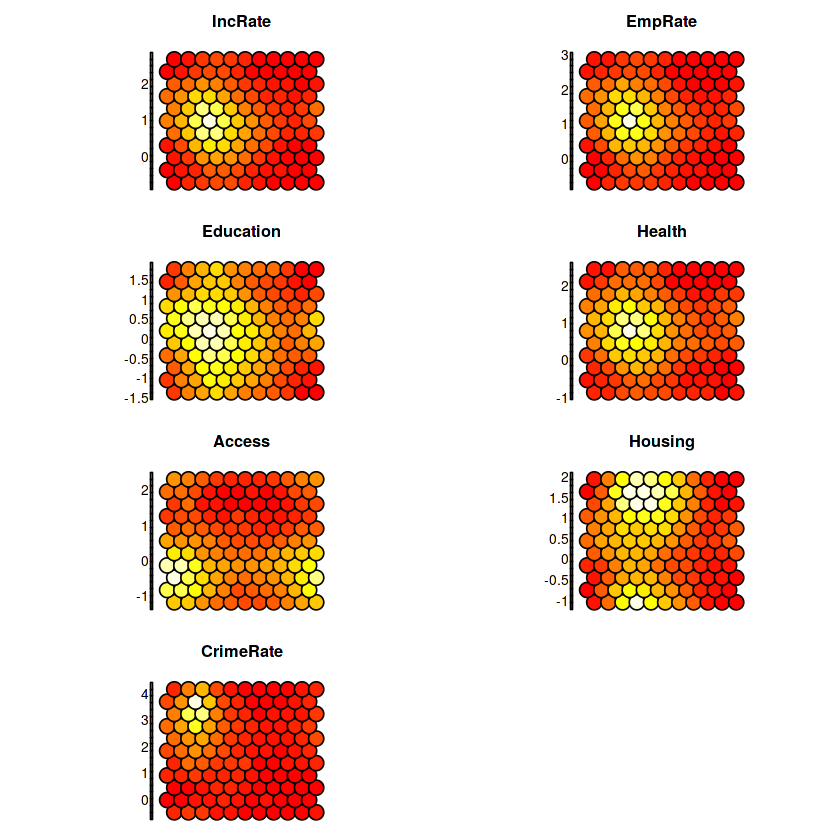

In [8]:
par(mfrow=c(4,2)) #this tells R to put 2 plots in each column and row 
plot(som_model, type = "property", property = getCodes(som_model)[,1], main=colnames(getCodes(som_model))[1])
plot(som_model, type = "property", property = getCodes(som_model)[,2], main=colnames(getCodes(som_model))[2])
plot(som_model, type = "property", property = getCodes(som_model)[,3], main=colnames(getCodes(som_model))[3])
plot(som_model, type = "property", property = getCodes(som_model)[,4], main=colnames(getCodes(som_model))[4])
plot(som_model, type = "property", property = getCodes(som_model)[,5], main=colnames(getCodes(som_model))[5])
plot(som_model, type = "property", property = getCodes(som_model)[,6], main=colnames(getCodes(som_model))[6])
plot(som_model, type = "property", property = getCodes(som_model)[,7], main=colnames(getCodes(som_model))[7])
#plot(som_model, type = "property", property = getCodes(som_model)[,8], main=colnames(getCodes(som_model))[8])

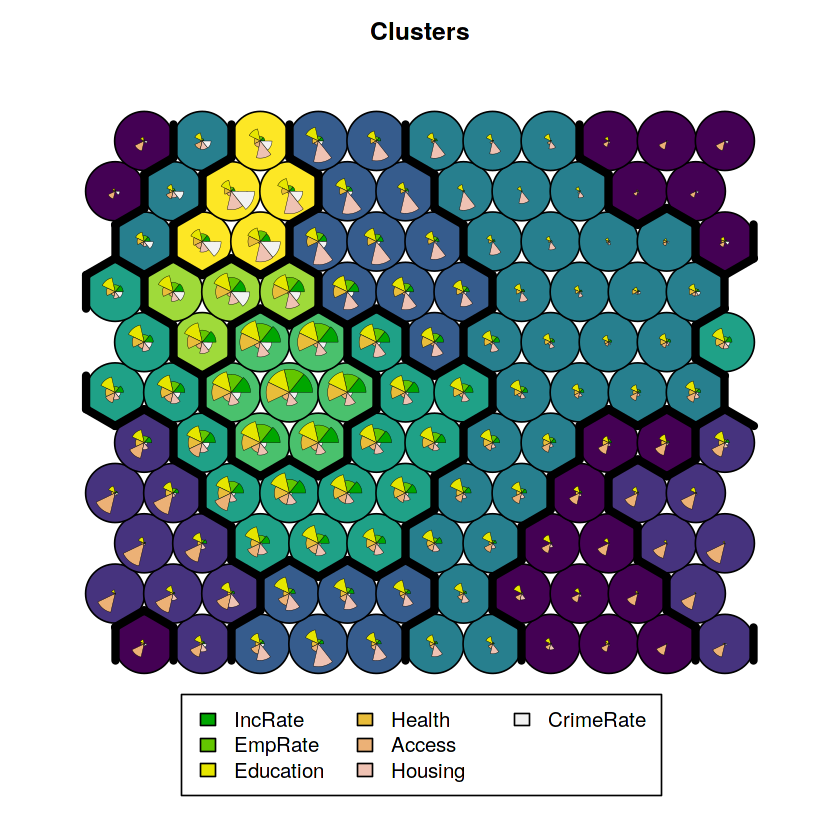

In [9]:
#determine the number of clusters
number_of_clusters <- 8
my_viridis <- viridis(number_of_clusters)

# plot the clusters of the SOM
som_cluster <- cutree(hclust(dist(getCodes(som_model))),number_of_clusters)
plot(som_model, type="codes", bgcol = my_viridis[som_cluster], main = "Clusters")
add.cluster.boundaries(som_model, som_cluster)

In [10]:
# export the clusters to a dataframe
cluster_details <- data.frame(id=edi.df$id,
                              cluster=som_cluster[som_model$unit.classif])

In [11]:
#join them to the shapefile
ed <- fortify(edinburgh_shape)
mappoints <- merge(ed, cluster_details, by="id")

Regions defined for each Polygons



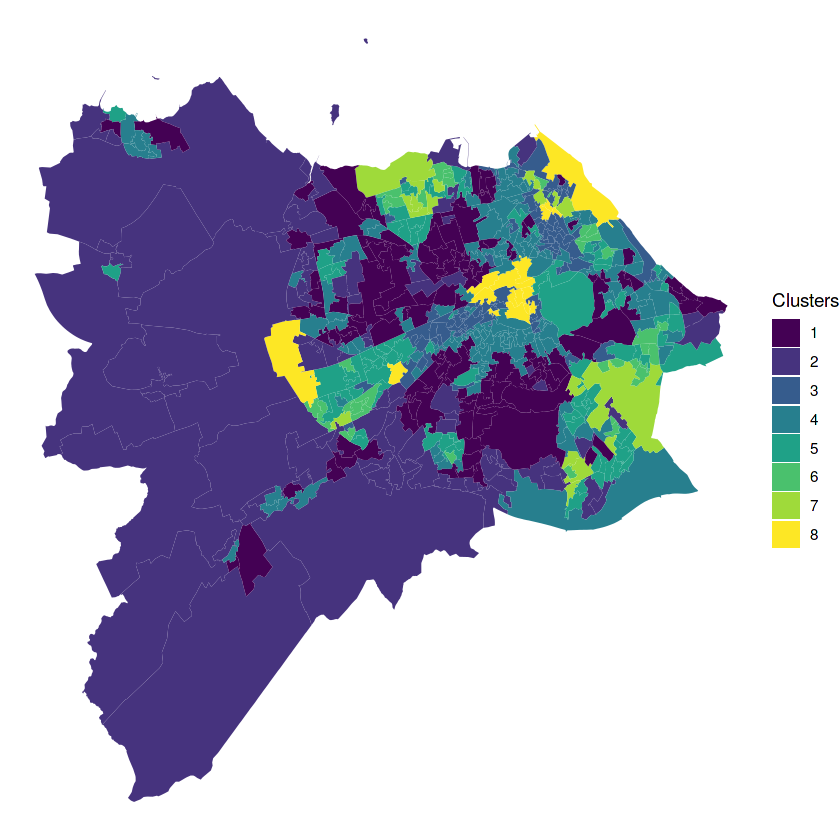

In [12]:
ggplot(data=mappoints, aes(x=long, y=lat, group=group, fill=factor(cluster))) +
geom_polygon(colour="transparent") + 
theme_void() +
scale_fill_manual(name = "Clusters", values = my_viridis)

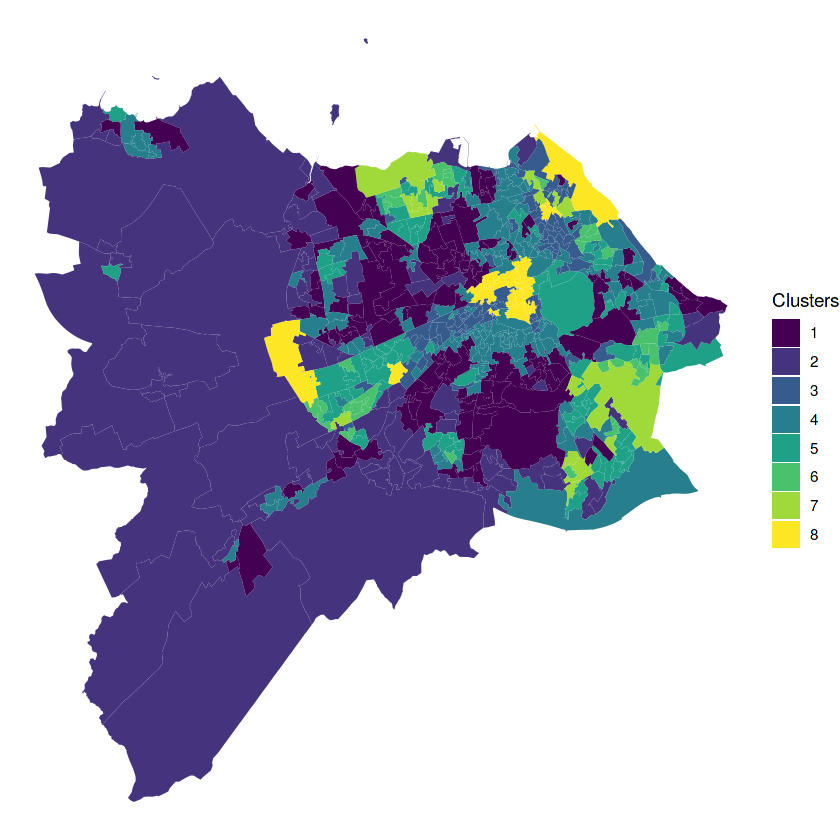
